In [1]:
import pandas as pd

df = pd.read_csv("data_clean2.csv")

df.head()

,HN,age,parity,previous preterm,GA,BMI,Cx dilate,Cx efface,MR,UC interval,UC duration,fever,WBC_CBC,neutrophil,WBC_UA,CS,tocolytic_group,tocolytic_seq,smoking,result
0,43055,27,2,0,196,23.3,1,80,0,4,40,0,12560,81.0,1-2,E.coli,"adalat,bricanyl","adalat,bricanyl",0,1
1,111428,27,1,0,216,19.2,1,25,0,4,50,0,13850,84.5,1-2,NG,adalat,adalat,0,1
2,344196,20,1,0,175,18.4,5,80,1,3,60,0,21540,86.2,3-5,gram post bacilli,"adalat,bricanyl","bricanyl,adalat",0,1
3,351689,27,1,0,208,31.8,7,80,1,2,50,0,9200,61.2,0-1,NG,bricanyl,bricanyl,0,0
4,382752,37,3,1,192,23.1,5,70,1,3,60,0,21790,94.4,2-3,NG,bricanyl,bricanyl,0,1


In [2]:
#check null
print(df.isnull().values.any())
df["WBC_UA"].unique()

#df[df["WBC_UA"] == '10-2']

False


,HN,age,parity,previous preterm,GA,BMI,Cx dilate,Cx efface,MR,UC interval,UC duration,fever,WBC_CBC,neutrophil,WBC_UA,CS,tocolytic_group,tocolytic_seq,smoking,result


In [3]:
df.columns.values

array(['HN', 'age', 'parity', 'previous preterm', 'GA', 'BMI',
       'Cx dilate', 'Cx efface', 'MR', 'UC interval', 'UC duration',
       'fever', 'WBC_CBC', 'neutrophil', 'WBC_UA', 'CS',
       'tocolytic_group', 'tocolytic_seq', 'smoking', 'result'],
      dtype=object)

In [4]:
#get only usable cols
only_cols = ['age', 'parity', 'previous preterm', 'GA', 'BMI',
       'Cx dilate', 'Cx efface', 'MR', 'UC interval', 'UC duration',
       'fever', 'WBC_CBC', 'neutrophil', 'WBC_UA', 'CS',
       'tocolytic_group', 'tocolytic_seq', 'smoking', 'result']
cat_cols = ['CS','tocolytic_group','tocolytic_seq','WBC_UA']
df_cut = df[only_cols]
df_cut_tran = pd.get_dummies(df_cut,columns = cat_cols)

print(df_cut_tran.shape)
print(df_cut_tran.head())
print(df_cut_tran.columns.values)

(200, 43)
   age  parity  previous preterm   GA   BMI  Cx dilate  Cx efface  MR  \
0   27       2                 0  196  23.3          1         80   0   
1   27       1                 0  216  19.2          1         25   0   
2   20       1                 0  175  18.4          5         80   1   
3   27       1                 0  208  31.8          7         80   1   
4   37       3                 1  192  23.1          5         70   1   

   UC interval  UC duration      ...        WBC_UA_0-1  WBC_UA_1-2  \
0            4           40      ...                 0           1   
1            4           50      ...                 0           1   
2            3           60      ...                 0           0   
3            2           50      ...                 1           0   
4            3           60      ...                 0           0   

   WBC_UA_10-20  WBC_UA_100  WBC_UA_2-3  WBC_UA_20-30  WBC_UA_3-5  \
0             0           0           0             0        

In [5]:
from sklearn.model_selection import train_test_split

X = df_cut_tran[df_cut_tran.columns.difference(['result'])]
Y = df_cut_tran[['result']]

#print(X.head())
#print(Y.head())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify = Y, random_state=888)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(160, 42)
(160, 1)
(40, 42)
(40, 1)


In [6]:
from sklearn.tree import DecisionTreeClassifier

#model1 = DecisionTreeClassifier(max_leaf_nodes=3,random_state=0)
model1 = DecisionTreeClassifier(min_samples_leaf=25,random_state=0)
model1.fit(X_train, Y_train.values.ravel())

Y_pred = model1.predict_proba(X_test)
print(Y_pred[0:1,])
print(Y_pred[0:1,1])
Y_pred = Y_pred[:,1]

check_d = {"Y_true":Y_test.values.ravel(), "Y_pred":Y_pred}
check_df = pd.DataFrame(check_d)

import numpy as np
np.set_printoptions(suppress=True)
check_df = check_df.sort_values(["Y_pred"], ascending=[0])

check_df.head(10)

[[0.09375 0.90625]]
[0.90625]


,Y_pred,Y_true
21,1.00000,1
38,1.00000,1
28,1.00000,1
4,1.00000,1
15,1.00000,1
6,1.00000,1
32,1.00000,1
13,1.00000,1
24,0.90625,1
12,0.90625,1


In [7]:
from sklearn.metrics import roc_auc_score

roc_auc_score(check_df["Y_true"], check_df["Y_pred"])

0.8034188034188035

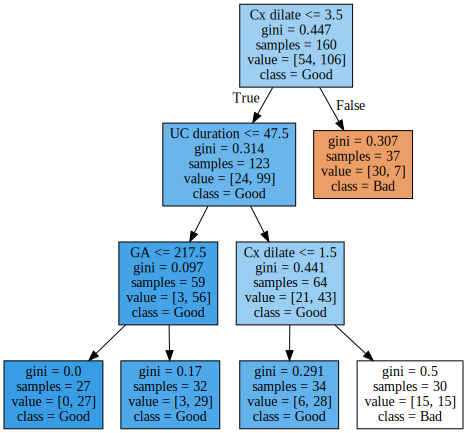

In [8]:
from sklearn.tree import  export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(model1, out_file=None
   , feature_names=X_train.columns.values, class_names=['Bad', 'Good'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))